Using device: cpu
Generating synthetic dataset...
Training samples: 8000
Validation samples: 2000

Starting training...


Epoch 5: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]



Epoch [5/50]
Train Loss: 0.0213, Train Acc: 0.9786
Val Loss: 0.0612, Val Acc: 0.9595
--------------------------------------------------


Epoch 10: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]



Epoch [10/50]
Train Loss: 0.0063, Train Acc: 0.9938
Val Loss: 0.0141, Val Acc: 0.9917
--------------------------------------------------


Epoch 15: 100%|██████████| 125/125 [00:26<00:00,  4.73it/s]



Epoch [15/50]
Train Loss: 0.0150, Train Acc: 0.9860
Val Loss: 0.0038, Val Acc: 0.9976
--------------------------------------------------


Epoch 20: 100%|██████████| 125/125 [00:26<00:00,  4.79it/s]



Epoch [20/50]
Train Loss: 0.0102, Train Acc: 0.9891
Val Loss: 0.0028, Val Acc: 0.9985
--------------------------------------------------


Epoch 25: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]



Epoch [25/50]
Train Loss: 0.0060, Train Acc: 0.9925
Val Loss: 0.0088, Val Acc: 0.9927
--------------------------------------------------


Epoch 30: 100%|██████████| 125/125 [00:26<00:00,  4.77it/s]



Epoch [30/50]
Train Loss: 0.0048, Train Acc: 0.9932
Val Loss: 0.0011, Val Acc: 0.9990
--------------------------------------------------


Epoch 35: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]



Epoch [35/50]
Train Loss: 0.0037, Train Acc: 0.9958
Val Loss: 0.0010, Val Acc: 0.9980
--------------------------------------------------


Epoch 40: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]



Epoch [40/50]
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0001, Val Acc: 1.0000
--------------------------------------------------


Epoch 45: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]



Epoch [45/50]
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Acc: 1.0000
--------------------------------------------------


Epoch 50: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]



Epoch [50/50]
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.0000, Val Acc: 1.0000
--------------------------------------------------
Training completed!

Testing model with examples:
Example 1:
Source:    [56  4 63 58 26 82 41 77 47 50]
Target:    [50 47 77 41 82 26 58 63  4 56]
Predicted: [50 47 77 41 82 26 58 63  4 56]
Correct:   True

Example 2:
Source:    [80 72 18  9 57 55 81 49 10 73]
Target:    [73 10 49 81 55 57  9 18 72 80]
Predicted: [73 10 49 81 55 57  9 18 72 80]
Correct:   True

Example 3:
Source:    [91 10 20 72  1 33 38 57 14 21]
Target:    [21 14 57 38 33  1 72 20 10 91]
Predicted: [21 14 57 38 33  1 72 20 10 91]
Correct:   True

Example 4:
Source:    [ 7 63 52 89 31 39 15 45 27 47]
Target:    [47 27 45 15 39 31 89 52 63  7]
Predicted: [47 27 45 15 39 31 89 52 63  7]
Correct:   True

Example 5:
Source:    [67 86 97 60  8 99  1 45 16 82]
Target:    [82 16 45  1 99  8 60 97 86 67]
Predicted: [82 16 45  1 99  8 60 97 86 67]
Correct:   True



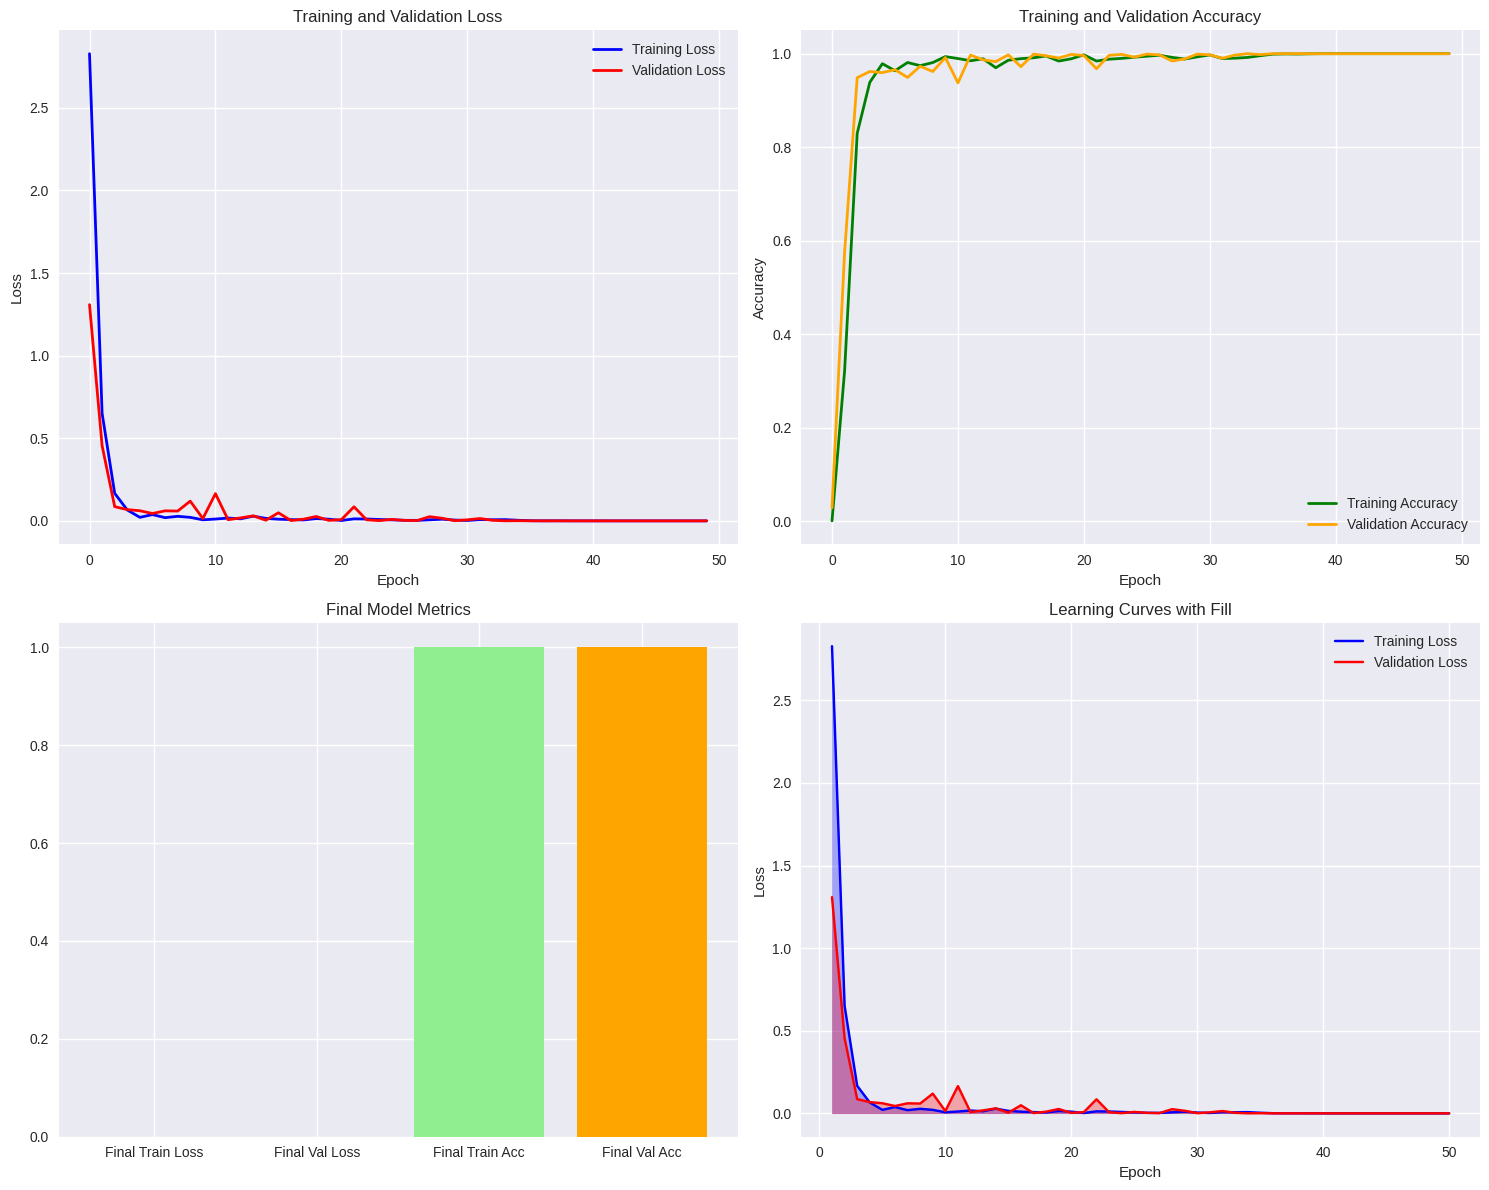

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== Dataset Generation ====================
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=10000, seq_length=10, vocab_size=100):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            source = [random.randint(1, self.vocab_size - 1) for _ in range(self.seq_length)]
            target = source[::-1]
            data.append((source, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source, target = self.data[idx]
        return torch.tensor(source, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# ==================== Attention Mechanism ====================
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        hidden = hidden.unsqueeze(0).repeat(seq_len, 1, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), 2)))
        attention = self.v(energy).squeeze(2)
        attention_weights = F.softmax(attention, dim=0).transpose(0, 1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs.transpose(0, 1)).squeeze(1)
        return context, attention_weights

# ==================== Encoder ====================
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

# ==================== Decoder with Attention ====================
class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=1):
        super(DecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, input_step, hidden, encoder_outputs):
        embedded = self.embedding(input_step).unsqueeze(1)
        context, attention_weights = self.attention(hidden[-1], encoder_outputs.transpose(0, 1))
        gru_input = torch.cat((embedded, context.unsqueeze(1)), 2)
        output, hidden = self.gru(gru_input, hidden)
        prediction = self.out(torch.cat((output.squeeze(1), context), 1))
        return prediction, hidden, attention_weights

# ==================== Seq2Seq Model with Attention ====================
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers=1):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = Encoder(vocab_size, embedding_size, hidden_size, num_layers)
        self.decoder = DecoderWithAttention(vocab_size, embedding_size, hidden_size, num_layers)
        self.vocab_size = vocab_size

    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = source.size(1)
        encoder_outputs, hidden = self.encoder(source)
        decoder_input = torch.zeros(batch_size, dtype=torch.long, device=source.device)
        decoder_hidden = hidden
        outputs = []
        attentions = []
        for t in range(target_len):
            output, decoder_hidden, attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            outputs.append(output)
            attentions.append(attention)
            if target is not None and random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t]
            else:
                decoder_input = output.argmax(1)
        return torch.stack(outputs, dim=1), torch.stack(attentions, dim=1)

# ==================== Training Configuration ====================
VOCAB_SIZE = 101
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
SEQ_LENGTH = 10

print("Generating synthetic dataset...")
dataset = SyntheticDataset(num_samples=10000, seq_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE-1)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

model = Seq2SeqWithAttention(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def calculate_accuracy(predictions, targets):
    pred_sequences = predictions.argmax(dim=2)
    correct = (pred_sequences == targets).all(dim=1).float()
    return correct.mean().item()

print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0
    epoch_train_acc = 0
    for source, target in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        source, target = source.to(device), target.to(device)
        optimizer.zero_grad()
        outputs, _ = model(source, target, teacher_forcing_ratio=0.5)
        loss = criterion(outputs.reshape(-1, VOCAB_SIZE), target.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        acc = calculate_accuracy(outputs, target)
        epoch_train_loss += loss.item()
        epoch_train_acc += acc
    model.eval()
    epoch_val_loss = 0
    epoch_val_acc = 0
    with torch.no_grad():
        for source, target in val_loader:
            source, target = source.to(device), target.to(device)
            outputs, _ = model(source, target, teacher_forcing_ratio=0)
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), target.reshape(-1))
            acc = calculate_accuracy(outputs, target)
            epoch_val_loss += loss.item()
            epoch_val_acc += acc
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_train_acc = epoch_train_acc / len(train_loader)
    avg_val_acc = epoch_val_acc / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)
    if (epoch + 1) % 5 == 0:
        print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print('-' * 50)

print("Training completed!")

# ==================== Model Testing ====================
def test_model_examples(model, dataset, num_examples=5):
    model.eval()
    with torch.no_grad():
        for i in range(num_examples):
            source, target = dataset[i]
            source_input = source.unsqueeze(0).to(device)
            outputs, _ = model(source_input, teacher_forcing_ratio=0)
            predicted = outputs.argmax(dim=2).squeeze(0).cpu().numpy()
            print(f"Example {i+1}:")
            print(f"Source:    {source.numpy()}")
            print(f"Target:    {target.numpy()}")
            print(f"Predicted: {predicted}")
            print(f"Correct:   {np.array_equal(target.numpy(), predicted)}\n")

print("\nTesting model with examples:")
test_model_examples(model, val_dataset, num_examples=5)

# ==================== Plotting Results ====================
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Training Accuracy', color='green', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

categories = ['Final Train Loss', 'Final Val Loss', 'Final Train Acc', 'Final Val Acc']
values = [train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']
ax3.bar(categories, values, color=colors)
ax3.set_title('Final Model Metrics')

epochs = range(1, NUM_EPOCHS + 1)
ax4.plot(epochs, train_losses, 'b-', label='Training Loss')
ax4.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax4.fill_between(epochs, train_losses, alpha=0.3, color='blue')
ax4.fill_between(epochs, val_losses, alpha=0.3, color='red')
ax4.set_title('Learning Curves with Fill')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

plt.tight_layout()
plt.show()
